In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

class DINOv2Dense:
    def __init__(self, model_name="facebook/dinov2-base"):
        self.model = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
        self.model.eval()

        # Standard DINOv2 transforms
        self.preprocess = transforms.Compose([
            transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(518),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
        ])

    def get_dense_features(self, image):

        # Convert RGBA → RGB
        if not isinstance(image, torch.Tensor):
            if image.mode != "RGB":
                image = image.convert("RGB")

            image = self.preprocess(image).unsqueeze(0)

        with torch.no_grad():
            feats = self.model.forward_features(image)

        patch_tokens = feats["x_norm_patchtokens"]  # [B, N, C]

        B, N, C = patch_tokens.shape
        H = W = int(N ** 0.5)

        patch_tokens = patch_tokens.view(B, H, W, C).permute(0, 3, 1, 2)
        patch_tokens = F.normalize(patch_tokens, dim=1)

        return patch_tokens



In [2]:
class DINOv2TextSegmentation:
    def __init__(self, dinov2_model="facebook/dinov2-base", clip_model="openai/clip-vit-base-patch16"):
        self.dino = DINOv2Dense(dinov2_model)

        self.tokenizer = CLIPTokenizer.from_pretrained(clip_model)
        self.text_encoder = CLIPTextModel.from_pretrained(clip_model)

    def get_text_features(self, prompt):
        tokens = self.tokenizer([prompt], return_tensors="pt", padding=True)
        with torch.no_grad():
            out = self.text_encoder(**tokens)
        return F.normalize(out.pooler_output, dim=-1)  # [1, 512]

    def similarity(self, image, text_prompt):
        feat = self.dino.get_dense_features(image)  # [1, C, Hp, Wp]
        text = self.get_text_features(text_prompt)  # [1, 512]

        if feat.shape[1] != text.shape[1]:
            text = F.pad(text, (0, feat.shape[1]-text.shape[1]))

        sim = (feat * text.unsqueeze(-1).unsqueeze(-1)).sum(dim=1)
        return sim

    # -------------------------
    #   NEW FUNCTION HERE
    # -------------------------
    def get_dense_embeddings(self, image):
        """
        Returns:
            emb_patch: [1, C, Hp, Wp]  # DINOv2 patch embeddings
            emb_up:    [1, C, H,  W]  # upsampled to full image size
        """

        # DINOv2 patch features
        emb_patch = self.dino.get_dense_features(image)

        # Image resolution
        if not isinstance(image, torch.Tensor):
            W, H = image.size
        else:
            H, W = image.shape[-2:]

        # Upsample embeddings
        emb_up = F.interpolate(
            emb_patch,
            size=(H, W),
            mode='bilinear',
            align_corners=False
        )

        return emb_patch, emb_up

    # Existing segment() stays unchanged
    def segment(self, image, text_prompt, threshold=0.3):

        sim = self.similarity(image, text_prompt)
        B, Hp, Wp = sim.shape

        sim_min = sim.amin(dim=(1,2), keepdim=True)
        sim_max = sim.amax(dim=(1,2), keepdim=True)
        sim_norm = (sim - sim_min) / (sim_max - sim_min + 1e-8)

        sim_scaled = sim_norm * 2 - 1
        patch_mask = (sim_scaled > threshold).float()

        if not isinstance(image, torch.Tensor):
            W, H = image.size
        else:
            H, W = image.shape[-2:]

        sim_up = F.interpolate(sim_scaled.unsqueeze(1),
                               size=(H, W),
                               mode='bicubic',
                               align_corners=False).squeeze(1)

        mask_up = F.interpolate(patch_mask.unsqueeze(1),
                                size=(H, W),
                                mode='nearest').squeeze(1)

        return mask_up, sim_up, sim_scaled

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


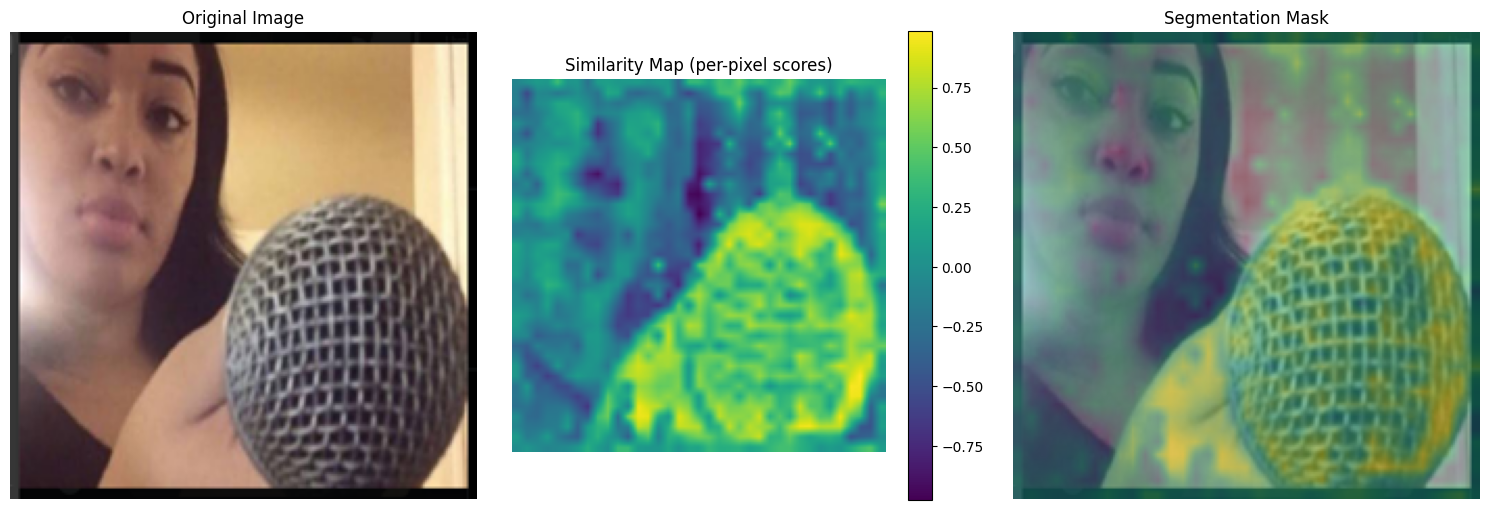

In [104]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Initialize
segmenter = DINOv2TextSegmentation()

# Load image
image = Image.open("/content/Screenshot from 2025-11-05 18-50-01.png")
image = image.resize((224, 224))
# Get per-pixel features and segmentation
mask, similarity_map, _ = segmenter.segment(image, "person", threshold=0.25)

# similarity_map contains per-pixel similarity scores (continuous values)
# mask contains binary segmentation (0 or 1)
import matplotlib.pyplot as plt
mask_np = mask[0].cpu().numpy()  # Remove batch dimension
similarity_np = similarity_map[0].detach().cpu().numpy()

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Similarity heatmap
im1 = axes[1].imshow(similarity_np)
axes[1].set_title("Similarity Map (per-pixel scores)")
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])

# Binary mask overlay
axes[2].imshow(image)
axes[2].imshow(similarity_np, alpha=0.5,)
axes[2].set_title("Segmentation Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [69]:
image.size, mask.shape, similarity_np.size

((224, 224), torch.Size([1, 37, 37]), 1369)